# Defining the Deep Convection Area (DCA)

In [1]:
import numpy as np
import netCDF4 as nc
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_style('dark')
from info import datadir, figdir, bounds_lon, bounds_lat, smooth_criminal

import warnings
warnings.filterwarnings('ignore')

### Loading data

Mean MLD field for months with max MLD > 1000 m:

In [2]:
# Indices of months where max MLD > 1000 m
large_mld_months = np.load(datadir+'large_mld_months.npy')

# Latitude and longitude
latlon = sio.loadmat(datadir+'latlon.mat')
lat = latlon['lat']
lon = latlon['lon']
Lon, Lat = np.meshgrid(lon, lat)

# MLD field
mld = sio.loadmat(datadir+'mld_field.mat')['mld_field']

Individual MLD fields for months with max MLD > 1000 m:

In [3]:
# Load the data set for monthly MLDs
fn =  '//zeus.nioz.nl/ocs/data/OSNAP/Reanalysis/CMEMS/ocean/monthly/raw/global-reanalysis-phy-001-030-monthly_MLD.nc'
ds = nc.Dataset(fn)
latm = ds['latitude'][:]
lonm = ds['longitude'][:]

# Select area of interest
ind_lat_lower = np.argwhere(latm==bounds_lat[0])[0][0]
ind_lat_upper = np.argwhere(latm==bounds_lat[1])[0][0]
ind_lon_left = np.argwhere(lonm==bounds_lon[0])[0][0]
ind_lon_right = np.argwhere(lonm==bounds_lon[1])[0][0]

# Load MLD data in area of interest
mld_monthly = ds['mlotst'][:,ind_lat_lower:ind_lat_upper+1,ind_lon_left:ind_lon_right+1]
mld_monthly = mld_monthly[:,::-1,:]

Depth-averaged temperature field:

In [4]:
# Coordinates
coords = sio.loadmat('../Data/propertiesIrminger_coords.mat')
lat = coords['lat'][0]
lon = coords['lon'][0]
LonLarge, LatLarge = np.meshgrid(lon,lat)

# Mean properties
prop_mean = sio.loadmat('../Data/propertiesIrminger_mean.mat')
T_mean = prop_mean['T']

Define the projection:

In [5]:
projection = ccrs.LambertConformal(central_longitude=np.mean(bounds_lon),central_latitude=np.mean(bounds_lat))

## Plotting MLD field averaged over months with max MLD > 1000 m

In [6]:
# Apply Gaussian filter for smoothing MLD field for contours
sigma=5
mld_smooth = smooth_criminal(mld,sigma)

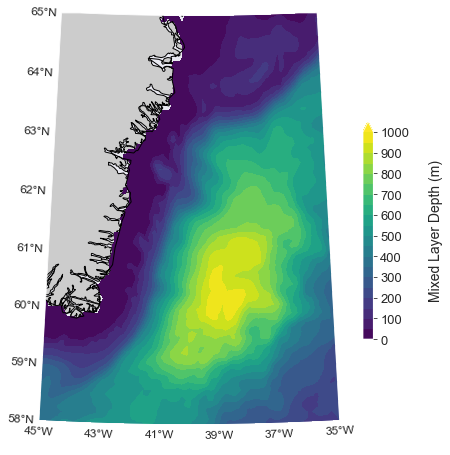

In [7]:
def plotFieldLC(ax,field,levels,ticks,ext,cmap,label,eps=0.015):
    # Plot field
    fieldplot = ax.contourf(Lon, Lat, field, levels=levels,extend=ext,cmap=cmap,transform=ccrs.PlateCarree())
    cbar = fig.colorbar(fieldplot, ax=ax, shrink = 0.5, anchor=(0.5,-0.75), ticks=ticks)
    cbar.set_label(label, fontsize=14)
    cbar.ax.tick_params(labelsize=13)
    cbar.ax.get_yaxis().labelpad = 20

    # Other figure settings
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor=(0.8,0.8,0.8))
    rect_lon=[bounds_lon[0]-eps, bounds_lon[1]+eps]
    rect_lat=[bounds_lat[0]-eps, bounds_lat[1]+eps]
    rect = mpath.Path([[rect_lon[0], rect_lat[0]],
                        [rect_lon[1], rect_lat[0]],
                        [rect_lon[1], rect_lat[1]],
                        [rect_lon[0], rect_lat[1]],
                        [rect_lon[0], rect_lat[0]],
                        ]).interpolated(20)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_extent([bounds_lon[0], bounds_lon[1], bounds_lat[0] - 0.5, bounds_lat[1]])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), alpha=0)
    gl.xlocator = mticker.FixedLocator(np.arange(bounds_lon[0],bounds_lon[1]+0.1,2))
    gl.ylocator = mticker.FixedLocator(np.arange(bounds_lat[0],bounds_lat[1]+0.1,1))
    gl.xlabels_bottom = True
    gl.x_inline = False
    gl.xlabel_style = {'size': 12}
    gl.ylabels_left = True
    gl.ylabel_style = {'size': 12}

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8), subplot_kw={'projection': projection})
plotFieldLC(ax, mld, np.arange(0,1050,50), np.arange(0,1100,100), 'max', 'viridis', "Mixed Layer Depth (m)")
plt.show()

## Which contour to work with? Compare against monthly MLD=1000 m contours and depth-averaged temperature field

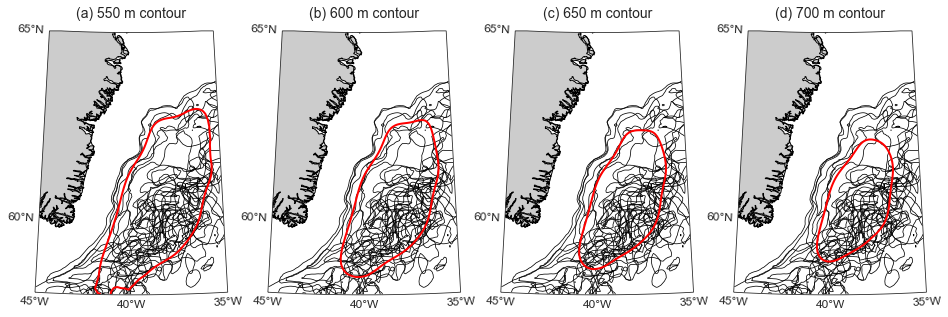

In [8]:
def plotMonthlyContoursLC(ax,field,lev,lev_monthly,title,eps=0.015):
    # For every month with max MLD > 1000 m, plot contour for MLD = lev_monthly
    for i in large_mld_months:
        cs = ax.contour(Lon,Lat,mld_monthly[i,:,:],levels=[lev_monthly],colors='black',linewidths=0.75,transform=ccrs.PlateCarree())
    # Plot contour line of desired field
    cslarge = ax.contour(Lon,Lat,field,levels=[lev],colors='red',linewidths=2,linestyles='solid',transform=ccrs.PlateCarree())
    
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor=(0.8,0.8,0.8))
    rect_lon=[bounds_lon[0]-eps, bounds_lon[1]+eps]
    rect_lat=[bounds_lat[0]-eps, bounds_lat[1]+eps]
    rect = mpath.Path([[rect_lon[0], rect_lat[0]],
                        [rect_lon[1], rect_lat[0]],
                        [rect_lon[1], rect_lat[1]],
                        [rect_lon[0], rect_lat[1]],
                        [rect_lon[0], rect_lat[0]],
                        ]).interpolated(20)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_extent([bounds_lon[0], bounds_lon[1], bounds_lat[0] - 0.5, bounds_lat[1]])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), alpha=0)
    gl.xlocator = mticker.FixedLocator([-45,-40,-35])
    gl.ylocator = mticker.FixedLocator([60,65])
    gl.xlabels_bottom = True
    gl.x_inline = False
    gl.xlabel_style = {'size': 12}
    gl.ylabels_left = True
    gl.ylabel_style = {'size': 12}
    ax.set_title(title,fontsize=14)

sns.set_style('white')
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,12), subplot_kw={'projection': projection})
plotMonthlyContoursLC(ax1,mld_smooth,550,1000,'(a) 550 m contour')
plotMonthlyContoursLC(ax2,mld_smooth,600,1000,'(b) 600 m contour')
plotMonthlyContoursLC(ax3,mld_smooth,650,1000,'(c) 650 m contour')
plotMonthlyContoursLC(ax4,mld_smooth,700,1000,'(d) 700 m contour')
plt.savefig(figdir+'compare_contours_MLDmonthly.pdf',bbox_inches='tight')
plt.show()

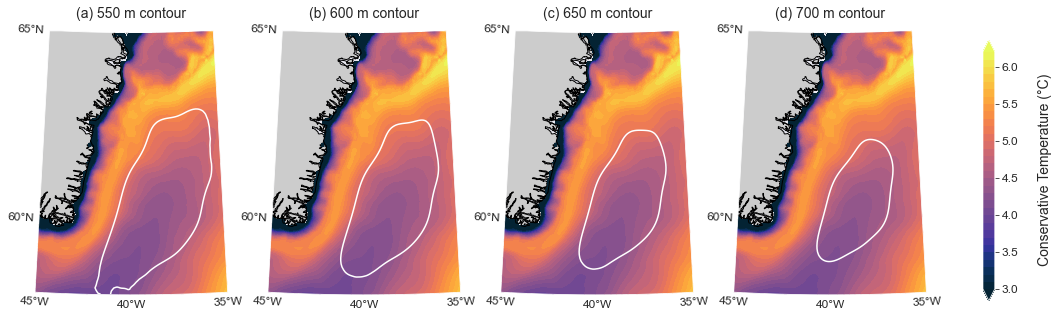

In [9]:
def plotFieldWithContourLC(ax,field,levels,ticks,ext,cmap,contour_value,title,eps=0.015):
    # Plot field
    fieldplot = ax.contourf(LonLarge, LatLarge, field, levels=levels,extend=ext,cmap=cmap,transform=ccrs.PlateCarree())
    CS_mld = ax.contour(Lon, Lat, mld_smooth, levels=contour_value, colors='white', transform=ccrs.PlateCarree())
    ax.set_title(title,fontsize=14)

    # Other figure settings
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor=(0.8,0.8,0.8))
    rect_lon=[bounds_lon[0]-eps, bounds_lon[1]+eps]
    rect_lat=[bounds_lat[0]-eps, bounds_lat[1]+eps]
    rect = mpath.Path([[rect_lon[0], rect_lat[0]],
                        [rect_lon[1], rect_lat[0]],
                        [rect_lon[1], rect_lat[1]],
                        [rect_lon[0], rect_lat[1]],
                        [rect_lon[0], rect_lat[0]],
                        ]).interpolated(20)
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)
    ax.set_boundary(rect_in_target)
    ax.set_extent([bounds_lon[0], bounds_lon[1], bounds_lat[0] - 0.5, bounds_lat[1]])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), alpha=0)
    gl.xlocator = mticker.FixedLocator([-45,-40,-35])
    gl.ylocator = mticker.FixedLocator([60,65])
    gl.xlabels_bottom = True
    gl.x_inline = False
    gl.xlabel_style = {'size': 12}
    gl.ylabels_left = True
    gl.ylabel_style = {'size': 12}
    
    return fieldplot


sns.set_style('dark')
fig,axes = plt.subplots(1,4,figsize=(20,12), subplot_kw={'projection': projection})
_ = plotFieldWithContourLC(axes[0], T_mean, np.arange(3,6.21,0.1), np.arange(3,6.21,1), 'both', 'cmo.thermal', 
                       [550],'(a) 550 m contour')
_ = plotFieldWithContourLC(axes[1], T_mean, np.arange(3,6.21,0.1), np.arange(3,6.21,1), 'both', 'cmo.thermal', 
                       [600],'(b) 600 m contour')
_ = plotFieldWithContourLC(axes[2], T_mean, np.arange(3,6.21,0.1), np.arange(3,6.21,1), 'both', 'cmo.thermal', 
                       [650],'(c) 650 m contour')
p = plotFieldWithContourLC(axes[3], T_mean, np.arange(3,6.21,0.1), np.arange(3,6.21,1), 'both', 'cmo.thermal', 
                       [700],'(d) 700 m contour')
cbar = fig.colorbar(p,ax=axes.ravel().tolist(),shrink=0.4,ticks=np.arange(3,6.2,0.5))
cbar.set_label('Conservative Temperature ('+'\u00B0'+'C)', fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.ax.get_yaxis().labelpad = 20
plt.savefig(figdir+'compare_contours_temp.pdf',bbox_inches='tight')
plt.show()

## We choose the mean MLD = 650 m contour:

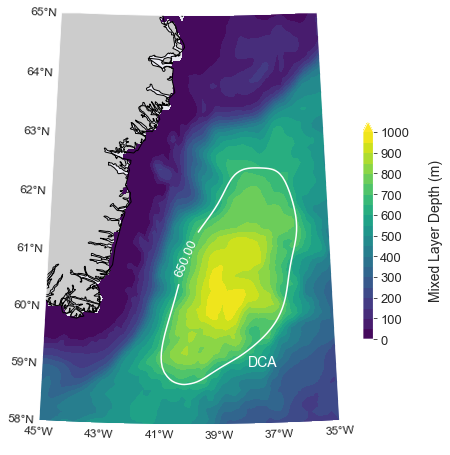

In [10]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,8), subplot_kw={'projection': projection})
plotFieldLC(ax, mld, np.arange(0,1050,50), np.arange(0,1100,100), 'max', 'viridis', "Mixed Layer Depth (m)")
CS_mld = ax.contour(Lon, Lat, mld_smooth, levels=[650], colors='white', transform=ccrs.PlateCarree())
ax.clabel(CS_mld, inline=1, fontsize=13, fmt='%.2f', colors='white')
ax.text(-38,59,'DCA',transform=ccrs.PlateCarree(),fontsize=14,color='white')
plt.savefig(figdir+'DCA_in_MLD_field.pdf',bbox_inches='tight')
plt.show()